In [234]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import pyplot
import plotly.express as px
from itertools import cycle
from sklearn import metrics
from numpy import where
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
import keyring


# Data

In [69]:
df_glass = pd.read_csv('glass (1).csv')
df_glass

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


# Preprocessing

In [70]:
# checking for nulls
df_glass.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [71]:
# checking for na
df_glass.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [72]:
# checking for duplicates
df_glass[df_glass.duplicated()]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


In [73]:
# one duplicate found and drop it.
df_glass.drop_duplicates(keep='last',inplace=True)

In [74]:
# checking one more time to make sure there is no duplicates.
df_glass.duplicated().sum()

0

In [75]:
# data is clean now
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


In [77]:
# renaming columns for better understanding.
df_glass.rename(columns = {'RI':'RI/Refractive index', 'Na':'Na/Sodium', 'Mg': 'MG/Magnesium', 'Al': 'Al/Aluminum', 'Si': 'Si/Silicon', 'K':'K/Potassium', 'Ca':'Ca/Calcium','Ba': 'Ba/Barium', 'Fe': 'Fe/Iron' }, inplace = True)
df_glass

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Objective: determine which class the glass sample belongs to

There are seven types of glass listed: they are :

- Class 1: building windows(float processed)
- Class 2: biulding windows(non-float processed)
- Class 3: vehicle windows(float processed)
- Class 4: vehicle windows(non-flaot processed)
- Class 5: containers
- Class 6: tableware
- Class 7: headlamps

In [10]:
#using describe to understand data better.
df_glass.describe()

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.518348,13.404085,2.679202,1.449484,72.655070,0.498873,8.954085,0.175869,0.057277,2.788732
std,0.003033,0.816662,1.443691,0.495925,0.773998,0.653185,1.425882,0.498245,0.097589,2.105130
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,1.519150,13.810000,3.600000,1.630000,73.090000,0.610000,9.150000,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


We can see from these plots that some features are skewed. That is why we will standardize.

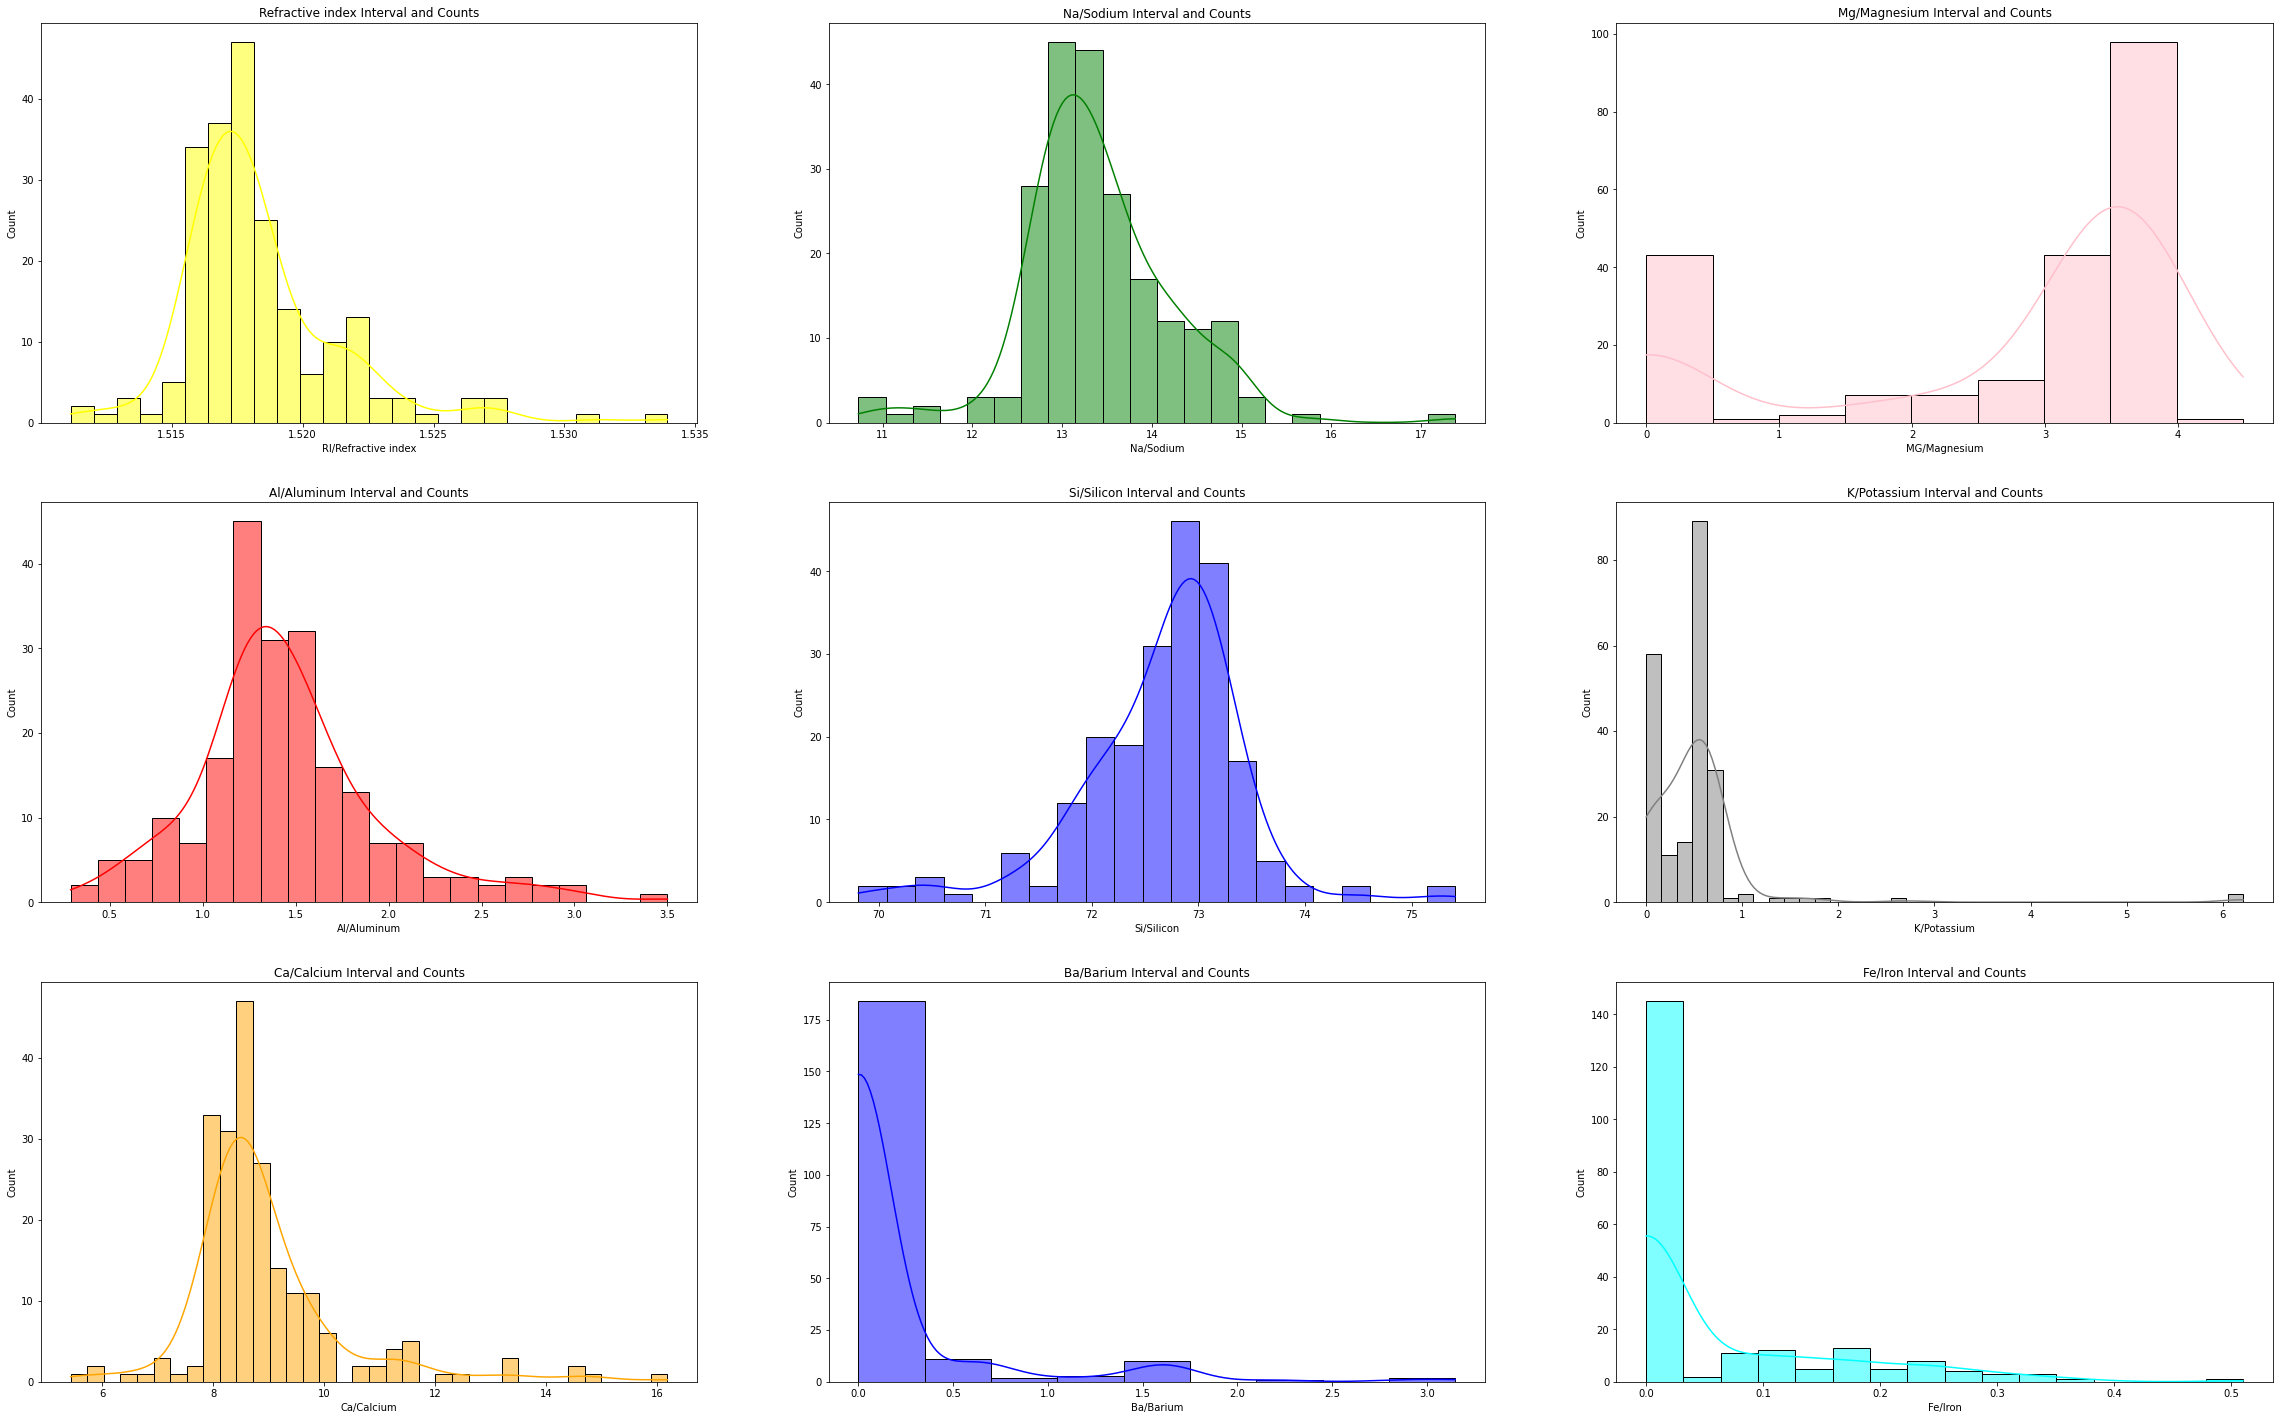

In [11]:
plt.figure(figsize=(40,25))
plt.subplot(3,3,1)
sns.histplot(df_glass['RI/Refractive index'],color = 'yellow',kde = True).set_title('Refractive index Interval and Counts')
plt.subplot(3,3,2)
sns.histplot(df_glass['Na/Sodium'],color = 'green',kde = True).set_title('Na/Sodium Interval and Counts')
plt.subplot(3,3,3)
sns.histplot(df_glass['MG/Magnesium'],kde = True,color = 'pink',).set_title('Mg/Magnesium Interval and Counts')
plt.subplot(3,3,4)
sns.histplot(df_glass['Al/Aluminum'],kde = True,color = 'red').set_title('Al/Aluminum Interval and Counts')
plt.subplot(3,3,5)
sns.histplot(df_glass['Si/Silicon'],color = 'blue',kde = True).set_title('Si/Silicon Interval and Counts')
plt.subplot(3,3,6)
sns.histplot(df_glass['K/Potassium'],color = 'grey',kde = True).set_title('K/Potassium Interval and Counts')
plt.subplot(3,3,7)
sns.histplot(df_glass['Ca/Calcium'],color = 'orange',kde = True).set_title('Ca/Calcium Interval and Counts')
plt.subplot(3,3,8)
sns.histplot(df_glass['Ba/Barium'],color = 'blue',kde = True).set_title('Ba/Barium Interval and Counts')
plt.subplot(3,3,9)
sns.histplot(df_glass['Fe/Iron'],color = 'cyan',kde = True).set_title('Fe/Iron Interval and Counts')
plt.show()

correlation matrix shows us that RI/refractive index highly correlated with Ca/calcium, RI/refractive index negatively correlated with Si/silicon.

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
RI/Refractive index,1.000000,-0.198802,-0.127526,-0.400973,-0.539000,-0.287645,0.811183,0.001679,0.147083,-0.160140
Na/Sodium,-0.198802,1.000000,-0.278420,0.167735,-0.064885,-0.264158,-0.278194,0.329080,-0.239374,0.508837
MG/Magnesium,-0.127526,-0.278420,1.000000,-0.479575,-0.162437,0.007617,-0.446197,-0.491818,0.085426,-0.744195
Al/Aluminum,-0.400973,0.167735,-0.479575,1.000000,-0.016195,0.323683,-0.258068,0.480642,-0.080583,0.597432
Si/Silicon,-0.539000,-0.064885,-0.162437,-0.016195,1.000000,-0.197281,-0.207145,-0.104389,-0.097717,0.147725
K/Potassium,-0.287645,-0.264158,0.007617,0.323683,-0.197281,1.000000,-0.317032,-0.043653,-0.009372,-0.012455
Ca/Calcium,0.811183,-0.278194,-0.446197,-0.258068,-0.207145,-0.317032,1.000000,-0.112208,0.126314,0.002677
Ba/Barium,0.001679,0.329080,-0.491818,0.480642,-0.104389,-0.043653,-0.112208,1.000000,-0.059729,0.574896
Fe/Iron,0.147083,-0.239374,0.085426,-0.080583,-0.097717,-0.009372,0.126314,-0.059729,1.000000,-0.191090
Type,-0.160140,0.508837,-0.744195,0.597432,0.147725,-0.012455,0.002677,0.574896,-0.191090,1.000000


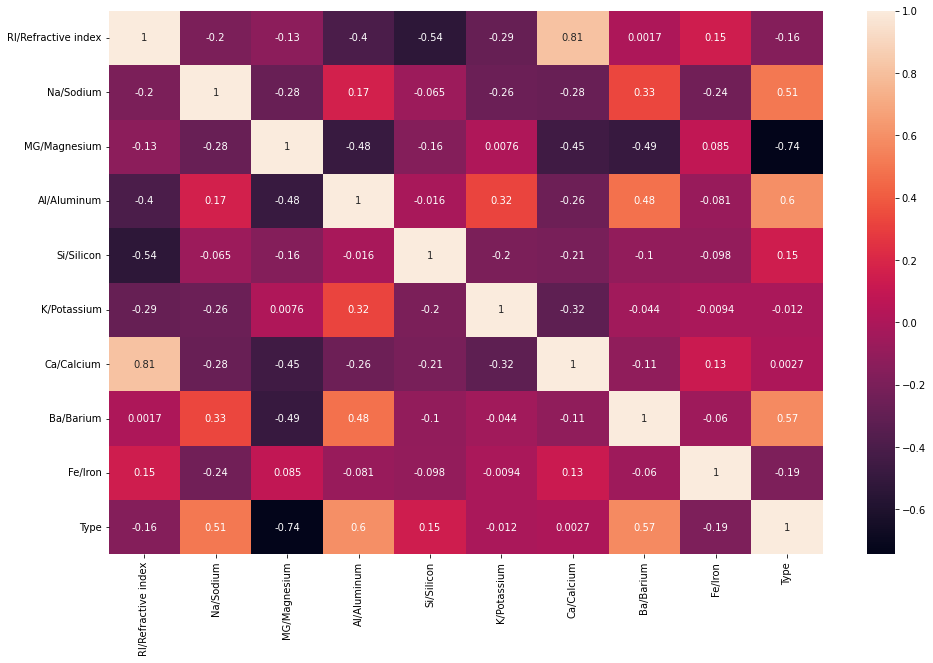

In [12]:
corr_matrix = df_glass.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix,annot=True)
corr_matrix

This plot used to check wheather output are balenced or not.

<AxesSubplot:xlabel='Type', ylabel='count'>

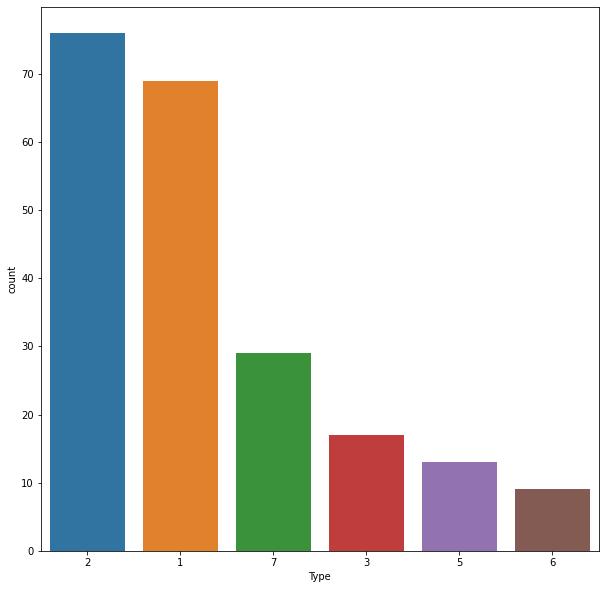

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(x='Type', data=df_glass, order=df_glass['Type'].value_counts().index)

ETL code start here: 

In [186]:
df = df_glass.drop(['RI/Refractive index','Na/Sodium','MG/Magnesium','Al/Aluminum','Si/Silicon','K/Potassium','Ca/Calcium','Ba/Barium','Fe/Iron'],axis=1,)
df
df_glass_output_obser_id = df.to_csv('observation_class.csv')

In [56]:
#df_glass converting to CSV
df_glass_no_output = df_glass.to_csv("Glass_1.csv")
df_glass_no_output

In [181]:
# all values inside connect() Postgress will know where you would like to connect.
con = psycopg2.connect(
host = 'localhost',
database = 'Glass_database',
user = 'postgres',
password = password_glass,
port='5432')

cur = con.cursor() # object we will be able to execute our commands
#execute method we will create tables.
cur.execute("""CREATE TABLE Observation_Class(Observation_ID integer PRIMARY KEY, 
                    Class_ID integer)""")
cur.execute("""CREATE TABLE Class_Information(Class_ID integer,
                    Class_Descriptions VARCHAR)""")
cur.execute("""CREATE TABLE Observation_Information(Observation_ID integer PRIMARY KEY,
                  RI_Refractive_Index float,Na_Sodium float,
                  Mg_Magnesium float,AI_Aluminum float,
                  Si_Silicon float,K_Potassium float,
                  Ca_Calcium float,Ba_Barium float,
                  Fe_Iron float)""")

con.commit() # when commit is called , the PostgressSQL engine will run all the queries at once
con.close()

In [187]:
con = psycopg2.connect(
host = 'localhost',
database = 'Glass_database',
user = 'postgres',
password = password_glass,
port='5432')

# cursor
cur = con.cursor()
# opening the Glass_1.csv
with open('observation_class.csv', 'r') as f:
    next(f) # Skip the header row.
    # load our file
    cur.copy_from(f, 'observation_class', sep=',') 

con.commit()

In [ ]:
con = psycopg2.connect(
host = 'localhost',
database = 'Glass_database',
user = 'postgres',
password = password_glass,
port='5432')

# cursor
cur = con.cursor()
# opening the Glass_1.csv
with open('Glass_1.csv, 'r') as f:
    next(f) # Skip the header row.
    # load our file
    cur.copy_from(f, 'observation_information', sep=',') 

con.commit()

Function to balance outputs.

In [110]:
def smote_balance(data_1):
    data = data_1.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable
    y = LabelEncoder().fit_transform(y)
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    return X,y

Function split and standardize data

In [118]:
def split_train_sc(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
    #Standardize
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return (X_train,X_test,y_train,y_test)                          

Function to model data using RandomForestClassifier.

In [124]:
def RandomForestClassifier(X_train,X_test,y_train,y_test):
    rf = RandomForestClassifier(random_state = 42)
    params_rf = {'n_estimators': [50,100,150,200,250],
                'max_depth': [4,6,8,10,12,None],
                'min_samples_leaf': [0.001,0.002,0.003,0.004,0.005],
                'max_features': [0.5,1,'log2','sqrt']}
    grid_rf = GridSearchCV(estimator = rf,param_grid = params_rf,cv = 5)
    grid_rf.fit(X_train,y_train)
    best_hyperparams = grid_rf.best_params_
    # Extract the best model from 'grid_rf'
    best_model = grid_rf.best_estimator_
    pred_train = best_model.predict(X_train)
    #Predict the test set labels
    y_pred_rf = best_model.predict(X_test)
    pred_glass_df = pd.DataFrame(X_test,columns = df_glass.columns[0:9])
    pred_glass_df['Type'] = y_test.tolist()
    pred_glass_df['predicted_type'] = y_pred_rf.tolist()
    return pred_glass_df.head(10)

In [125]:
RandomForestClassifier(X_train,X_test,y_train,y_test)

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type,predicted_type
0,0.146797,1.458910,-0.716526,0.175044,-0.080554,-0.577599,0.444195,-0.400461,-0.543693,4,4
1,1.317749,0.765367,1.119699,-1.945297,-1.059495,-0.443428,0.196005,-0.400461,-0.543693,0,0
2,0.489431,-1.068197,-1.388363,0.146771,1.384418,-0.154667,1.562955,-0.400461,-0.152913,3,3
3,-0.970156,-0.912363,0.948863,0.022344,0.561218,0.219025,-0.872648,-0.400461,2.128894,0,0
4,-0.778513,-0.640354,0.840737,-0.522214,0.508975,0.056663,-0.506848,-0.400461,-0.543693,2,2
5,-0.915306,1.726544,-1.417523,1.729501,0.559571,-0.516612,-0.329360,0.652074,-0.543693,5,5
6,-1.980074,-0.688413,-1.417523,2.648200,-2.412932,6.996949,-1.678269,-0.400461,-0.543693,3,3
7,-0.467955,-1.469369,0.389085,0.144294,0.331890,0.276215,-0.045379,-0.400461,-0.543693,1,1
8,0.017070,0.831646,0.112471,0.080501,-0.293266,-0.577599,0.069138,-0.400461,-0.543693,4,4
9,-0.327465,-1.108928,0.947009,-0.450159,0.597518,0.166439,-0.428753,-0.400461,0.925022,0,0


Train Accuracy is high which means it is not underfitting

In [205]:
#Train Accuracy_score
print(accuracy_score(y_train,pred_train))

1.0


Test Accuracy is high which means it is not overfitting

In [132]:
# Test Accuracy_score
print(accuracy_score(y_test,y_pred_rf))

0.967391304347826


In [131]:
#Classification_report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.89      0.92        19
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.97        92
   macro avg       0.97      0.97      0.97        92
weighted avg       0.97      0.97      0.97        92



ROC curve Plot for each class

In [164]:
def plot_roc_curve(y_test,y_pred):
    num_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test,classes =np.arange(num_classes))
    y_pred = label_binarize(y_pred,classes=np.arange(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_ = roc_curve(y_test[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
        
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'],_ = roc_curve(y_test.ravel(),y_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
    
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr,fpr[i], tpr[i])
        
        
    # Finally average it and compute AUC
    mean_tpr/=num_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'],tpr['macro'])
    
    # Plot all ROC curves
    # plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr['micro'],tpr['micro'],
            label = 'Micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),
            color = 'deeppink', linestyle=':', linewidth=4,)
    
    plt.plot(fpr['macro'],tpr['macro'],
            label = 'macro-average ROC curve (area={0:0.2f})'.format(roc_auc['macro']),
            color='navy', linestyle=':',linewidth=4,)
    
    colors = cycle(['aqua','darkorange','darkgreen','yellow','blue'])
    for i, color in zip(range(num_classes),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=lw,
                label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]),)
        
        
        plt.plot([0,1],[0,1], 'k--',lw =lw)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Glass identification ROC curve')
        plt.legend()

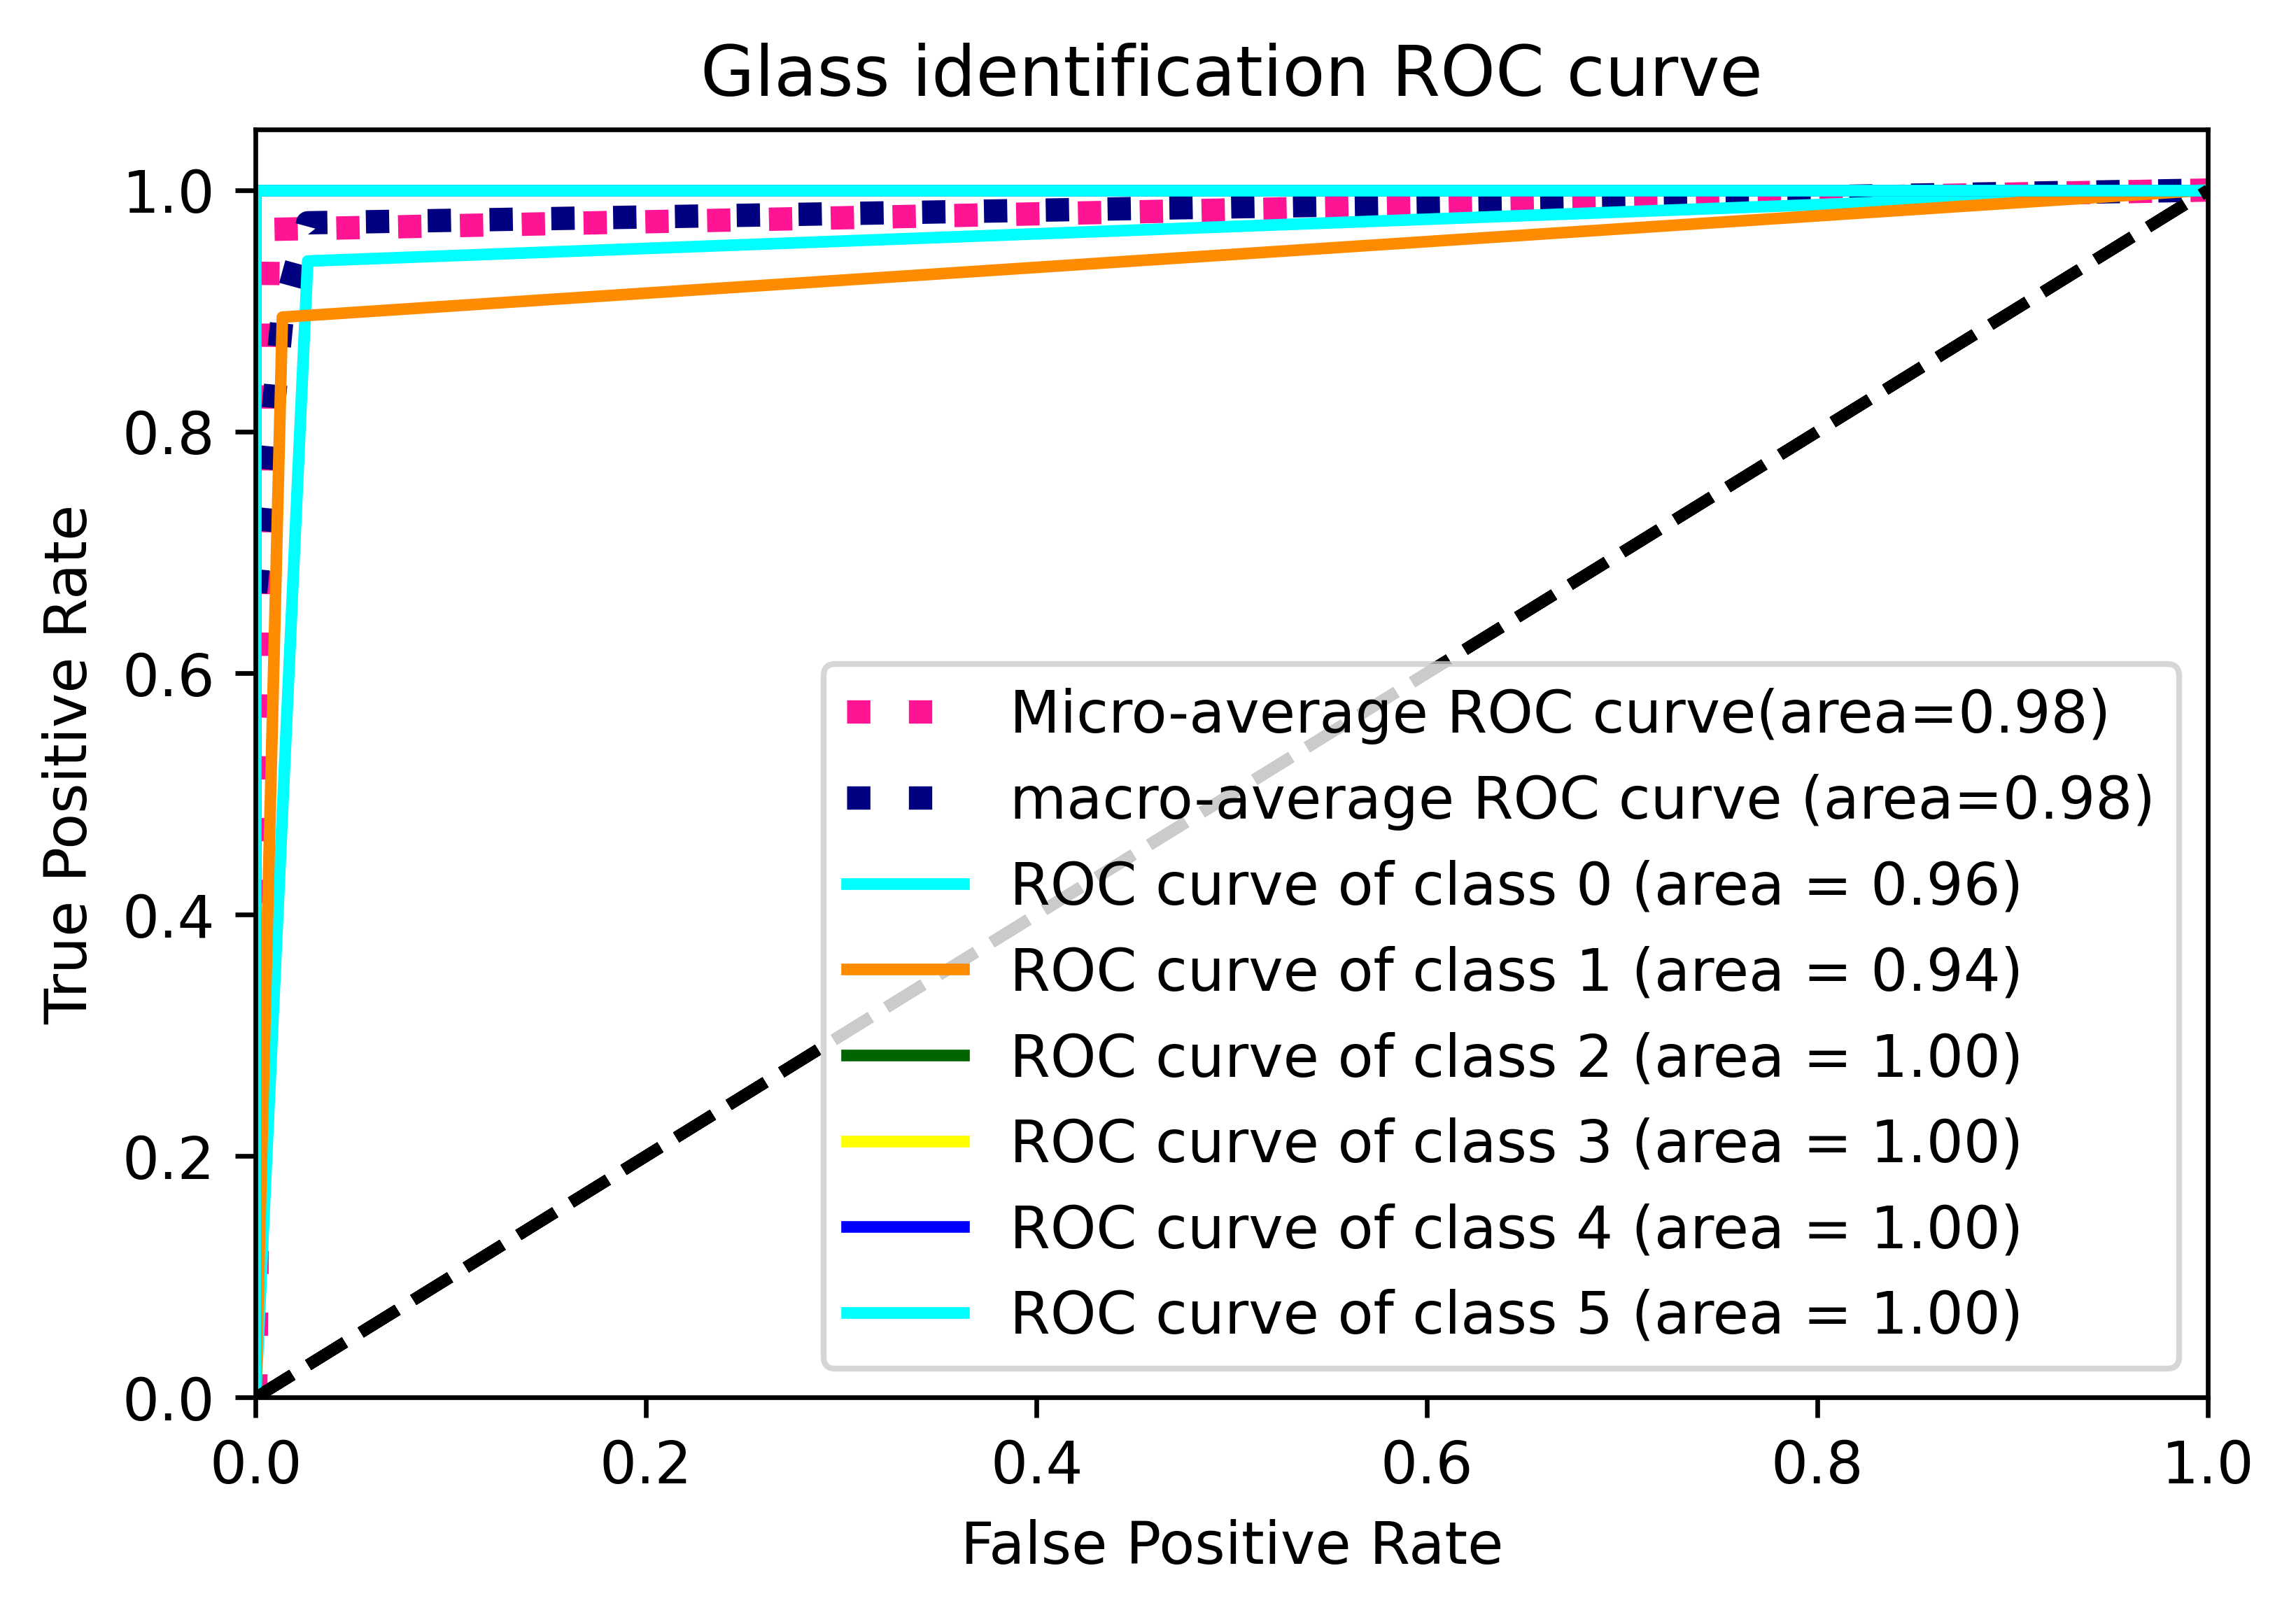

In [165]:
plot_roc_curve(y_test,y_pred_rf)

Features Importances: we can see that MG/Magnesium is the most important feature.

In [225]:
df_glass_1 = df_glass.drop('Type', axis=1)
d = {'features':df_glass_1.columns,'FI':rf.feature_importances_}
df = pd.DataFrame(d)
df = df.sort_values(by='FI', ascending=0)
fig = px.bar_polar(df, r="FI", theta="features",
                   color="features", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

# Queries:

In [223]:
con = psycopg2.connect(
host = 'localhost',
database = 'Glass_database',
user = 'postgres',
password = password_glass,
port='5432')

# cursor
cur = con.cursor()
cur.execute('''SELECT AVG(observation_information.na_sodium)as sodium,class_information.class_descriptions,observation_class.class_id
FROM  observation_information
LEFT JOIN observation_class
ON observation_information.observation_id = observation_class.class_id
LEFT JOIN class_information
ON observation_class.class_id = class_information.class_id
GROUP BY class_information.class_descriptions,observation_class.class_id
ORDER BY sodium desc;''')
#records = cur.fetchall()
#print(records)
for row in cur:
    print("Na/Sodium: " + str(row[0]) +", descriptions: "+str(row[1])+ ", Type: " +str(row[2]))
cur.close()
con.close()

Na/Sodium: 13.88999999999999, descriptions: building windows( float processed), Type: 1
Na/Sodium: 13.529999999999982, descriptions: building windows(non-float processed), Type: 2
Na/Sodium: 13.406763285024155, descriptions: None, Type: None
Na/Sodium: 13.299999999999999, descriptions: tableware, Type: 6
Na/Sodium: 13.210000000000006, descriptions: vehicle windows(float processed), Type: 3
Na/Sodium: 13.149999999999988, descriptions: headlamps, Type: 7
Na/Sodium: 12.789999999999996, descriptions: containers, Type: 5


In [222]:
con = psycopg2.connect(
host = 'localhost',
database = 'Glass_database',
user = 'postgres',
password = password_glass,
port='5432')

# cursor
cur = con.cursor()
cur.execute('''SELECT MAX(observation_information.mg_magnesium)as magnesium,class_information.class_descriptions,observation_class.class_id
FROM observation_information
LEFT JOIN observation_class
ON observation_information.observation_id = observation_class.class_id
LEFT JOIN class_information
ON observation_class.class_id = class_information.class_id
GROUP BY class_information.class_descriptions,observation_class.class_id
ORDER BY magnesium desc;''')
#records = cur.fetchall()
#print(records)
for row in cur:
    print("Mg/Magnesium: " + str(row[0]) +", descriptions: "+str(row[1])+ ", Type: " +str(row[2]))
cur.close()
con.close()

Mg/Magnesium: 4.49, descriptions: None, Type: None
Mg/Magnesium: 3.69, descriptions: vehicle windows(float processed), Type: 3
Mg/Magnesium: 3.61, descriptions: headlamps, Type: 7
Mg/Magnesium: 3.61, descriptions: containers, Type: 5
Mg/Magnesium: 3.6, descriptions: tableware, Type: 6
Mg/Magnesium: 3.6, descriptions: building windows( float processed), Type: 1
Mg/Magnesium: 3.55, descriptions: building windows(non-float processed), Type: 2
